# Self-Driving Car Engineer Nanodegree

## Project: Build a Traffic Sign Recognition Classifier


---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle
import pandas as pd
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt


training_file = 'train.p'
validation_file= 'valid.p'
testing_file = 'test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']
signnames = pd.read_csv('signnames.csv')['SignName']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image.

**THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [2]:
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of validation examples
n_validation = len(X_valid)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = np.unique(y_train).size

print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Speed limit (20km/h)


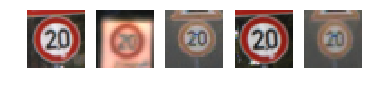

Speed limit (30km/h)


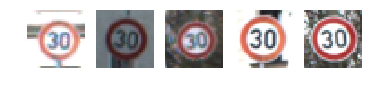

Speed limit (50km/h)


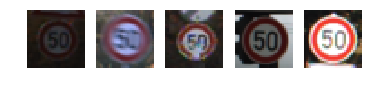

Speed limit (60km/h)


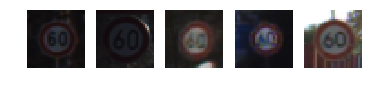

Speed limit (70km/h)


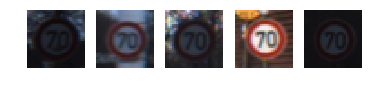

Speed limit (80km/h)


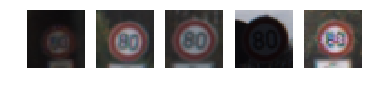

End of speed limit (80km/h)


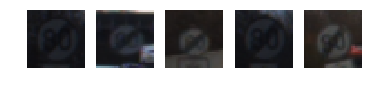

Speed limit (100km/h)


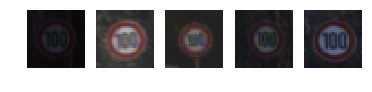

Speed limit (120km/h)


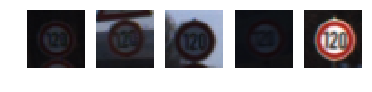

No passing


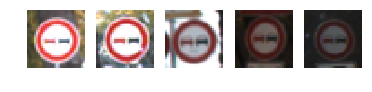

No passing for vehicles over 3.5 metric tons


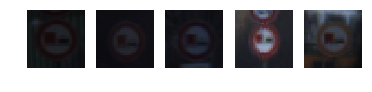

Right-of-way at the next intersection


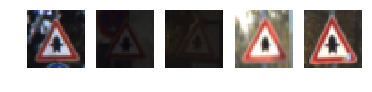

Priority road


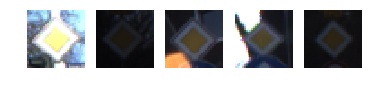

Yield


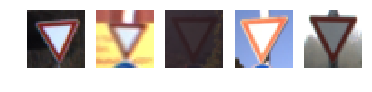

Stop


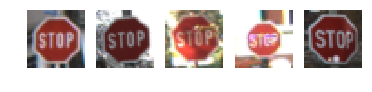

No vehicles


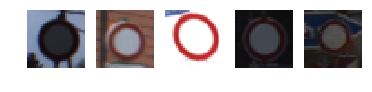

Vehicles over 3.5 metric tons prohibited


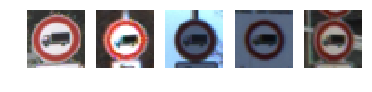

No entry


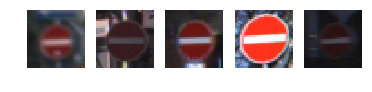

General caution


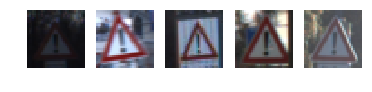

Dangerous curve to the left


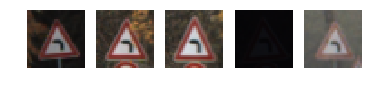

Dangerous curve to the right


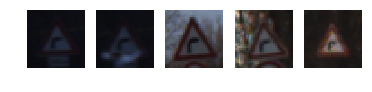

Double curve


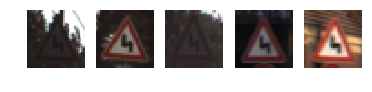

Bumpy road


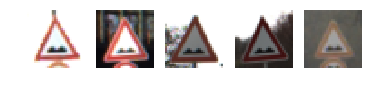

Slippery road


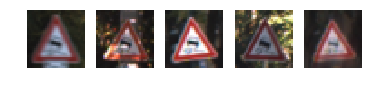

Road narrows on the right


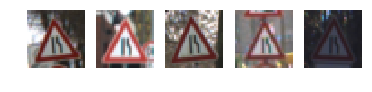

Road work


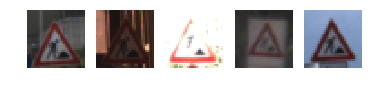

Traffic signals


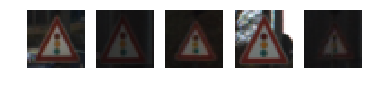

Pedestrians


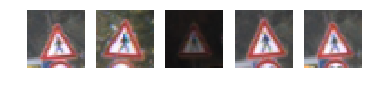

Children crossing


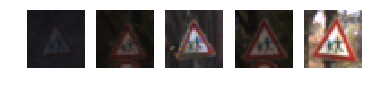

Bicycles crossing


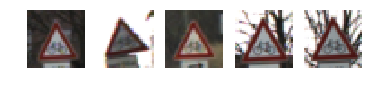

Beware of ice/snow


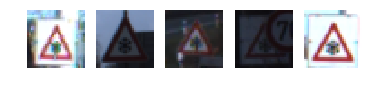

Wild animals crossing


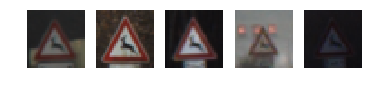

End of all speed and passing limits


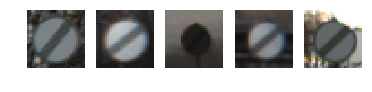

Turn right ahead


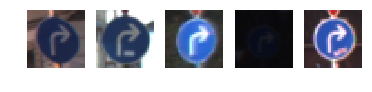

Turn left ahead


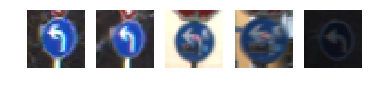

Ahead only


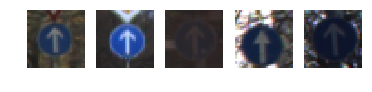

Go straight or right


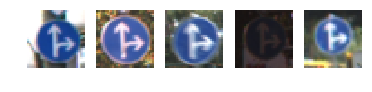

Go straight or left


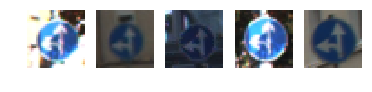

Keep right


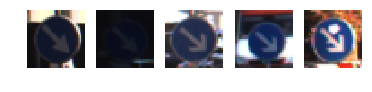

Keep left


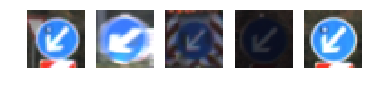

Roundabout mandatory


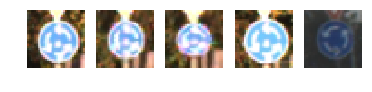

End of no passing


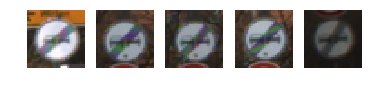

End of no passing by vehicles over 3.5 metric tons


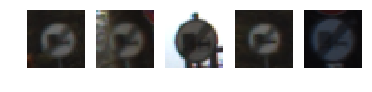

In [3]:
n = 5  # Examples to display

# Iterate all classes
for c in range(n_classes):  
    idx = np.where(y_train == c)  # Find index for class
    
    n_images = X_train[np.random.choice(idx[0], n)]  # Pick n random images to display
    
    f, axes = plt.subplots(1, n)
    print(signnames[c])
    
    for i, image in enumerate(n_images):
        axes[i].imshow(image)
        axes[i].grid(False)
        axes[i].axis('off')
    plt.show()

## Data Visualization:

### 1. Training Data:

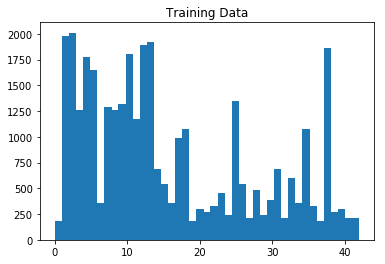

In [4]:
hist, bins = np.histogram(y_train, bins=n_classes)
center = (bins[:-1] + bins[1:]) / 2

plt.title('Training Data')
plt.bar(center, hist, align='center', width=1)
plt.show()

### 2. Validation Data:

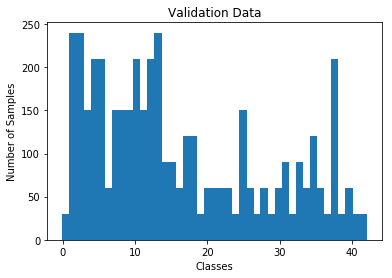

In [5]:
hist, bins = np.histogram(y_valid, bins=n_classes)
center = (bins[:-1] + bins[1:]) / 2

plt.title('Validation Data')
plt.bar(center, hist, align='center', width=1)
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.show()

### 3. Testing Data:

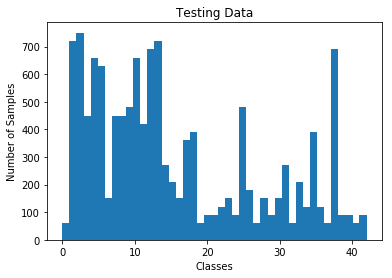

In [6]:
hist, bins = np.histogram(y_test, bins=n_classes)
center = (bins[:-1] + bins[1:]) / 2

plt.title('Testing Data')
plt.bar(center, hist, align='center', width=1)
plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.show()

----

## Step 2: Design and Test a Model Architecture

### Pre-process the Data Set (grayscale, equalization, normalization)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

In [7]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.

def grayscale(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return gray

def normalize(img):
    mini, maxi = np.min(img), np.max(img)
    return (img - mini) / (maxi - mini) * 2 - 1

def equalize(image):
    return cv2.equalizeHist(image)

def pre_processing(img):
    gray = grayscale(img)
    equalized = equalize(gray)
    normalized = normalize(equalized)
    return np.expand_dims(normalized, axis=2)

def preprocess(dataset):
    return np.array([pre_processing(img) for img in dataset])

def bright(dataset):
    return dataset*1.2

In [8]:
X_train_pre_processed = preprocess(X_train)
X_valid_pre_processed = preprocess(X_valid)
X_test_pre_processed = preprocess(X_test)

X_train_pre_processed = bright(X_train_pre_processed)
X_valid_pre_processed = bright(X_valid_pre_processed)
X_test_pre_processed = bright(X_test_pre_processed)

### Display Pre-processed Data:

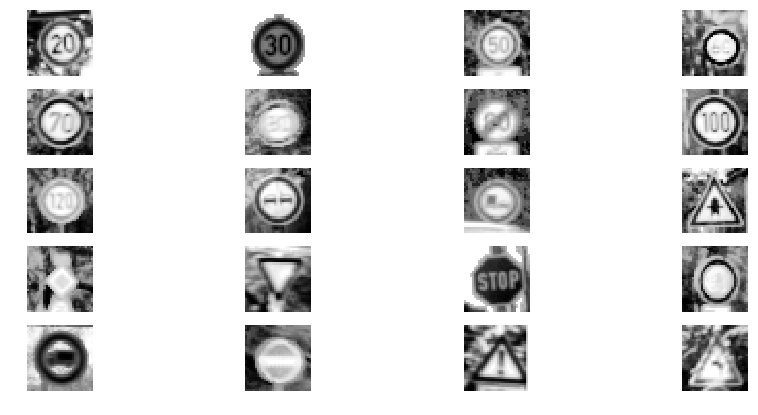

In [9]:
f, axes = plt.subplots(5, 4)
f.set_size_inches(15, 7)
c = 0
for row in axes:
    for ax in row:
        if c < n_classes:
            im = (X_train_pre_processed[np.random.choice(np.where(y_train == c)[0], 1)])
            ax.imshow(im[0,:,:,0], cmap='gray')
        ax.grid(False)
        ax.axis('off')
        c += 1
plt.show()

***

### Model Architecture

In [10]:
### Define your architecture here.

from tensorflow.contrib.layers import flatten

def LeNet_traffic(x):
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    keep_pro = 0.95
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    # Activation Layer.
    conv1 = tf.nn.relu(conv1)
    # Pooling Layer. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    
    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    # Activation Layer.
    conv2 = tf.nn.relu(conv2)
    # Pooling Layer. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    
    # Flatten Layer. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    # Activation Layer.
    fc1    = tf.nn.relu(fc1)
    # Dropout Layer.
    dropout1 = tf.nn.dropout(fc1, keep_pro)
    
    
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(dropout1, fc2_W) + fc2_b
    # Activation.
    fc2    = tf.nn.relu(fc2)
    # Dropout Layer.
    dropout2 = tf.nn.dropout(fc2, keep_pro)

    
    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(dropout2, fc3_W) + fc3_b

    return logits, conv1, conv2

## Train, Validate and Test the Model

### Features and Labels:

In [11]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

### Training Pipeline:

In [12]:
rate = 0.001

logits, conv1, conv2 = LeNet_traffic(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

### Model Evaluation:

In [13]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        
        total_accuracy += (accuracy * len(batch_x))
    
    return total_accuracy / num_examples

In [14]:
EPOCHS = 20
BATCH_SIZE = 64

### Train the Model:

In [15]:
from sklearn.utils import shuffle

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train_pre_processed)
    
    print("Training...")
    print()
    
    for i in range(EPOCHS):
        X_train_pre_processed, y_train = shuffle(X_train_pre_processed, y_train)
        
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            
            batch_x, batch_y = X_train_pre_processed[offset:end], y_train[offset:end]
            
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid_pre_processed, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, './lenet_traffic')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.826

EPOCH 2 ...
Validation Accuracy = 0.881

EPOCH 3 ...
Validation Accuracy = 0.896

EPOCH 4 ...
Validation Accuracy = 0.911

EPOCH 5 ...
Validation Accuracy = 0.912

EPOCH 6 ...
Validation Accuracy = 0.922

EPOCH 7 ...
Validation Accuracy = 0.913

EPOCH 8 ...
Validation Accuracy = 0.928

EPOCH 9 ...
Validation Accuracy = 0.927

EPOCH 10 ...
Validation Accuracy = 0.936

EPOCH 11 ...
Validation Accuracy = 0.933

EPOCH 12 ...
Validation Accuracy = 0.937

EPOCH 13 ...
Validation Accuracy = 0.939

EPOCH 14 ...
Validation Accuracy = 0.935

EPOCH 15 ...
Validation Accuracy = 0.922

EPOCH 16 ...
Validation Accuracy = 0.949

EPOCH 17 ...
Validation Accuracy = 0.943

EPOCH 18 ...
Validation Accuracy = 0.946

EPOCH 19 ...
Validation Accuracy = 0.937

EPOCH 20 ...
Validation Accuracy = 0.945

Model saved


### Evaluate Testing Accuracy:

In [16]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver2 = tf.train.import_meta_graph('./lenet_traffic.meta')
    saver2.restore(sess, "./lenet_traffic")
    test_accuracy = evaluate(X_test_pre_processed, y_test)
    print("Test Set Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet_traffic
Test Set Accuracy = 0.920


### Evaluate Training Accuracy:

In [17]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver2 = tf.train.import_meta_graph('./lenet_traffic.meta')
    saver2.restore(sess, "./lenet_traffic")
    test_accuracy = evaluate(X_train_pre_processed, y_train)
    print("Training Set Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet_traffic
Training Set Accuracy = 0.998


---

## Step 3: Test a Model on New Images

### Load and Output the Images

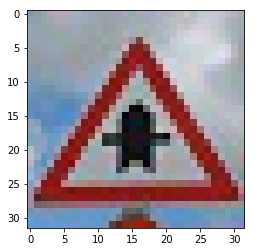

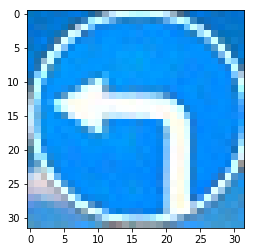

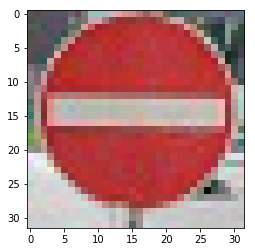

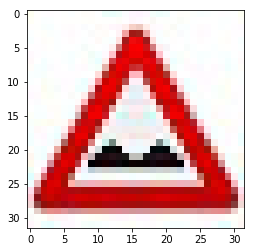

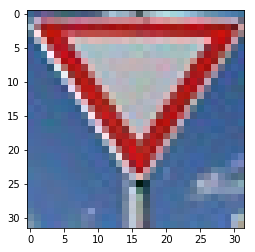

In [92]:
import glob
    
my_images = []

for i, img in enumerate(glob.glob('./test_images/*.jpg')):
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     image = cv2.resize(image, (32, 32))
    plt.imshow(image)
    plt.show()
    cv2.waitKey(500)
    my_images.append(image)

my_images = np.asarray(my_images)

In [93]:
my_labels = [11, 34, 17, 22, 13]

processed_images = preprocess(my_images)
processed_images = bright(processed_images)

### Predict the Sign Type for Each Image

In [94]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

with tf.Session() as sess:
    saver2 = tf.train.import_meta_graph('./lenet_traffic.meta')
    saver2.restore(sess, "./lenet_traffic")
    OUT = sess.run(tf.argmax(logits, 1), feed_dict={x: processed_images, y: my_labels})
    
print("Predicted Signs:                                      Actual Signs")
print('Sign 1: ', signnames[OUT[0]],'                       ', 'Sign 1: ',signnames[my_labels[0]])
print('Sign 2: ', signnames[OUT[1]],'                       ', 'Sign 2: ',signnames[my_labels[1]])
print('Sign 3: ', signnames[OUT[2]],'                       ', 'Sign 3: ',signnames[my_labels[2]])
print('Sign 4: ', signnames[OUT[3]],'                       ', 'Sign 4: ',signnames[my_labels[3]])
print('Sign 5: ', signnames[OUT[4]],'                       ', 'Sign 5: ',signnames[my_labels[4]])

INFO:tensorflow:Restoring parameters from ./lenet_traffic
Predicted Signs:                                      Actual Signs
Sign 1:  Right-of-way at the next intersection                         Sign 1:  Right-of-way at the next intersection
Sign 2:  No entry                         Sign 2:  Turn left ahead
Sign 3:  No entry                         Sign 3:  No entry
Sign 4:  Bumpy road                         Sign 4:  Bumpy road
Sign 5:  Yield                         Sign 5:  Yield


### Analyze Performance

In [95]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver2 = tf.train.import_meta_graph('./lenet_traffic.meta')
    saver2.restore(sess, "./lenet_traffic")
    my_accuracy = evaluate(processed_images, my_labels)
    print("Test Set Accuracy = {:.3f}".format(my_accuracy))

INFO:tensorflow:Restoring parameters from ./lenet_traffic
Test Set Accuracy = 0.800


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

INFO:tensorflow:Restoring parameters from ./lenet_traffic
Probabilities for top 5 predictions for each image:
0 [  8.48721147e-01   1.51278317e-01   5.29286126e-07   4.77951048e-08
   3.01347114e-10]
Predicted Classes [11 30 23 20 27]
  


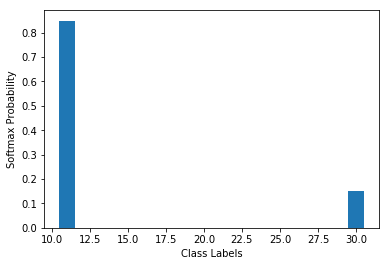

1 [  6.66917920e-01   2.65732855e-01   6.34310767e-02   3.45655065e-03
   2.55111139e-04]
Predicted Classes [34 30 17  9 19]
  


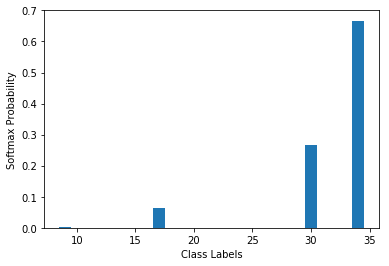

2 [  8.08581769e-01   1.87575638e-01   3.84220434e-03   2.70957173e-07
   1.25959090e-07]
Predicted Classes [17 33  9 12 14]
  


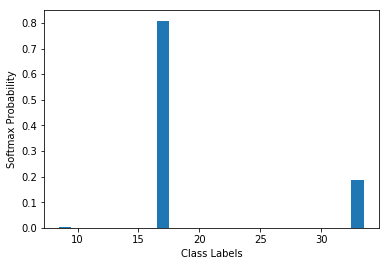

3 [  9.99972224e-01   2.71780027e-05   5.53384723e-07   1.71557755e-08
   8.05702260e-09]
Predicted Classes [22  3 31 28  0]
  


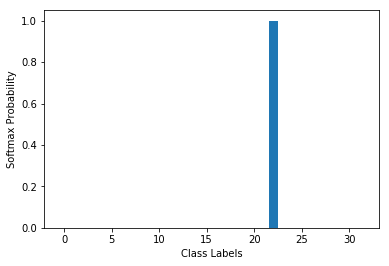

4 [  1.00000000e+00   1.46566892e-17   1.83421986e-18   7.65241018e-19
   1.18232579e-24]
Predicted Classes [13  3 34 35  2]
  


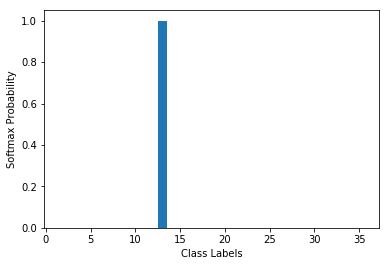

In [96]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

with tf.Session() as sess:
    saver2 = tf.train.import_meta_graph('./lenet_traffic.meta')
    saver2.restore(sess, "./lenet_traffic")
    OUT = sess.run(tf.nn.top_k(tf.nn.softmax(logits), 5), feed_dict={x: processed_images, y: my_labels})
           
print("Probabilities for top 5 predictions for each image:")
for i in range(len(my_labels)):
    y_val = OUT[0][i].T
    x_val = OUT[1][i].T
    print(i, y_val)
    print('Predicted Classes', x_val)
    print('  ')
    
    plt.bar(x_val, y_val, width=1)
    plt.xlabel('Class Labels')
    plt.ylabel('Softmax Probability')
    plt.show()

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


INFO:tensorflow:Restoring parameters from .\lenet_traffic
Feature maps for Speed limit (60km/h)
First convolutional layer
Second convolutional layer


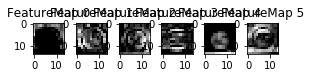

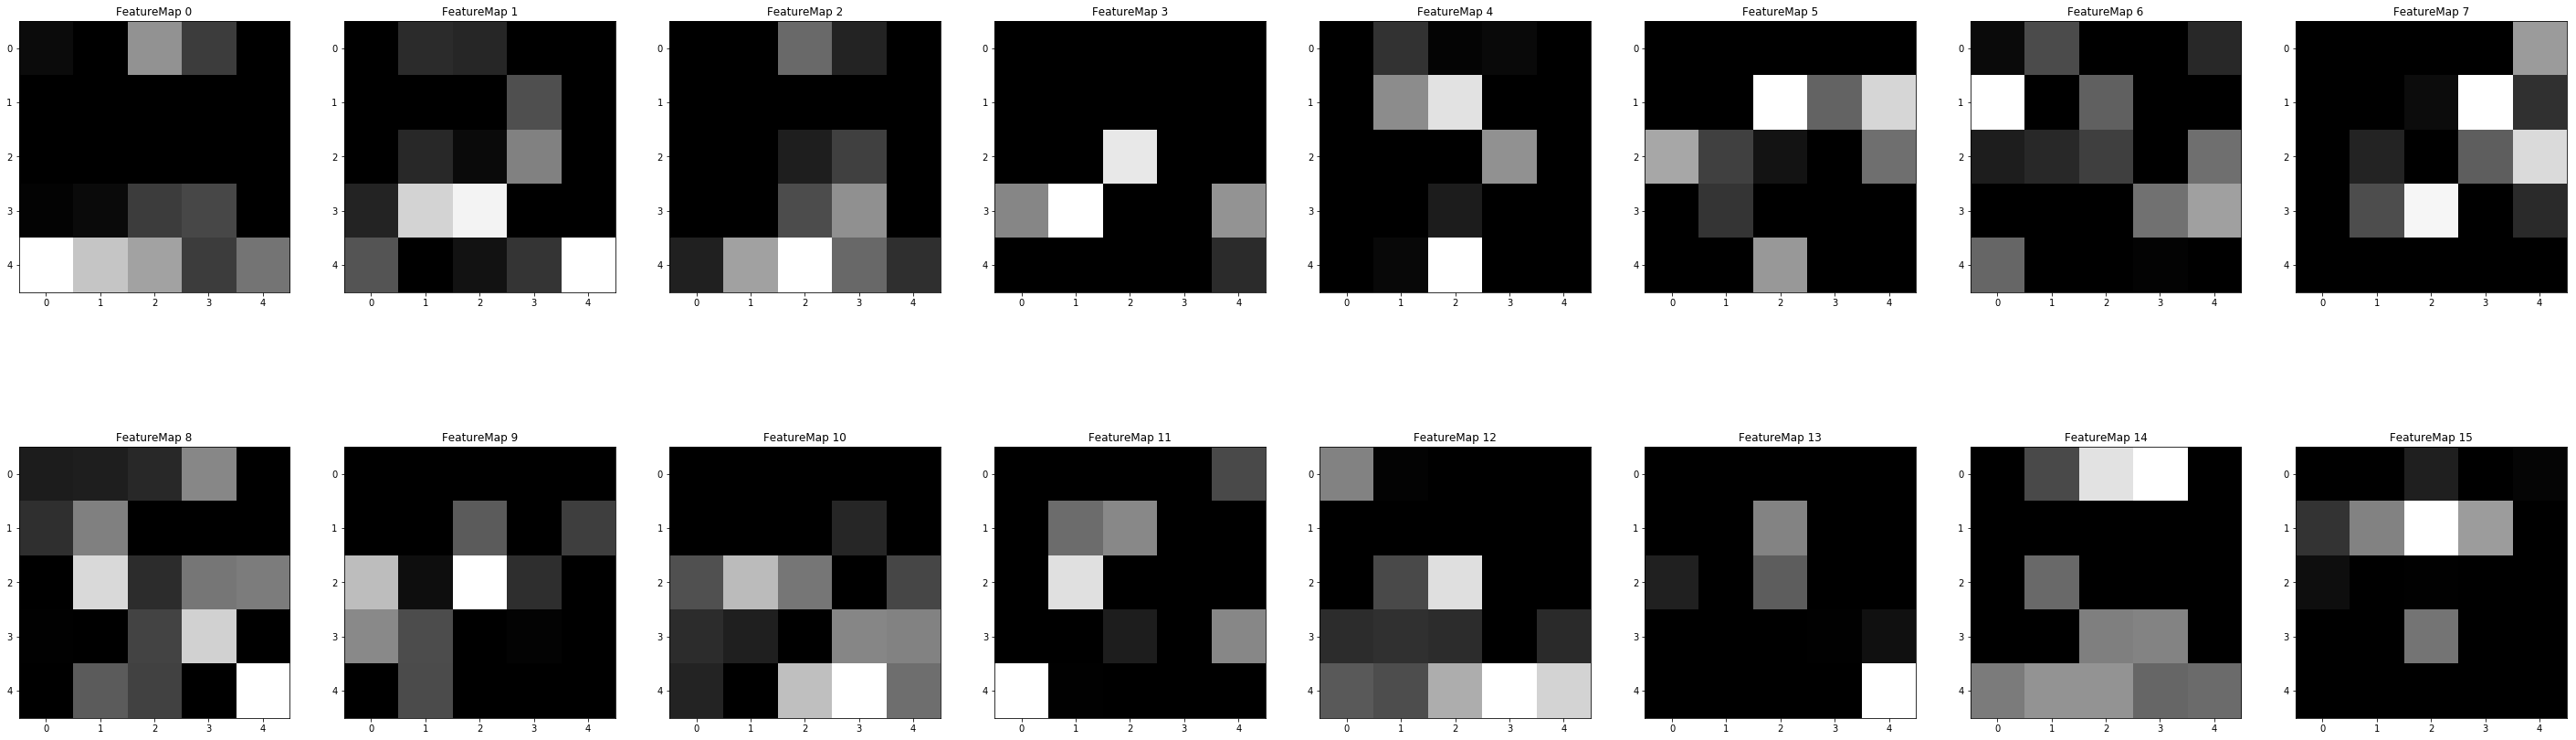

In [97]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(50,50))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
            
            
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    ix = int(np.random.random() * X_test_pre_processed.shape[0])
    random_image = np.expand_dims(X_test_pre_processed[ix], axis=0)
    print('Feature maps for', signnames[y_test[ix]])
    show_img = X_test_pre_processed[ix]
    plt.imshow(show_img.squeeze(), cmap='gray')
    print('First convolutional layer')
    outputFeatureMap(random_image, conv1, plt_num=1)
    print('Second convolutional layer')
    outputFeatureMap(random_image, conv2, plt_num=2)
    plt.show()